# Phealing Case Study

## Problématique
Lorsque le pharmacien détecte une erreur d'interaction entre 2 médicaments d'une ordonnance, il a la possibilité de remplacer un des 2 médicaments qui interagit par un autre médicament. A ce moment, il pourrait être pertinent de l'accompagner dans le choix du médicament de remplacement. Le médicament que le pharmacien doit remplacer est prescrit pour une ou plusieurs indications (par exemple : fièvre, douleurs, abcès dentaires, etc.). Par exemple un choix de médicament de remplacement serait un médicament indiqué pour ces mêmes indications (par exemple le paracétamol et l'ibuprofène sont deux molécules indiquées contre des maux de tête).

## Solution envisagée
Toutefois, on pourrait peut-être rendre la suggestion encore plus pertinente en se basant sur l'ensemble des autres médicaments de la prescription, ou des prescriptions passées, voir en prenant en compte les associations 'usuelles' de médicaments. Nous souhaiterions donc étudier, avec ce jeu de données, la possibilité de suggérer des assocations courantes de médicaments. Est-il possible de suggérer sur la base de l'historique des prescriptions, quel médicament peut convenir pour compléter l'ordonnance ?

## Tâches
En commençant par une analyse descriptive du jeu de données, vous essayerez de répondre à cette question. Surtout, vous pourrez décrire les grandes phases d'un projet qui consisterait à implémenter cette fonctionnalité, comme par exemple :
* données supplémentaires à acquérir
* choix des algorithmes et métriques ?
* Implémentation & test, etc.

> On précise que les interactions entre médicaments est une donnée externes déjà connue, que nous pouvons prendre comme contrainte dans la suggestion.

In [21]:
import json
import gzip
from data import PRESCRIPTION_PATH
import pandas as pd
import numpy as np

def read_dataset(path_to_dataset):
    with open(path_to_dataset) as f:
        prescriptions = [json.loads(line) for line in f]
    return prescriptions

## Distribution des médicaments prescrits

In [44]:
prescriptions = read_dataset(PRESCRIPTION_PATH)

medecine_df = pd.DataFrame.from_records(sum(prescriptions, []))
medecine_dictionary = pd.DataFrame(
    medecine_df.groupby(["key", "label"]).size()
).reset_index().rename(columns={0: "frequency"})

medecine_dictionary.sort_values("frequency", ascending=False).head(10)


,key,label,frequency
214,1052,Paracétamol 1000 mg comprimé,267
1188,7024,Colecalciferol 100 000 iU/(2.mL) solution voie...,155
475,2323,Paracétamol 24 mg/mL solution voie orale,77
1351,8977,Oméprazole 20 mg gélule,66
10,57,Paracétamol 500 mg comprimé,66
250,1160,Prednisolone 20 mg comprimé,61
756,3725,Acide acétylsalicylique 75 mg poudre orale car...,58
352,1597,Paracétamol 500 mg gélule,46
771,3842,Tixocortol 1 % suspension voie nasale,43
163,878,Ibuprofene 400 mg comprime,39


<Axes: ylabel='Frequency'>

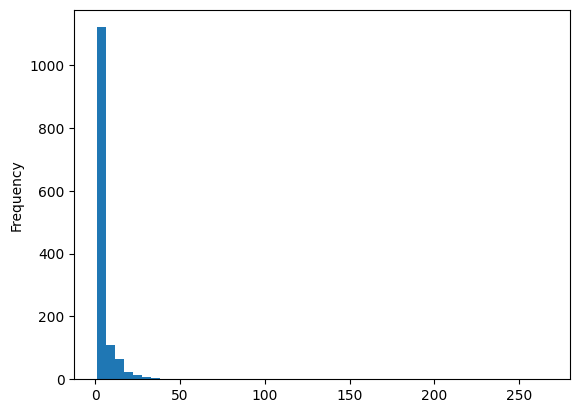

In [45]:
medecine_dictionary["frequency"].plot(kind="hist", bins=50)

In [42]:
medecine_dictionary["frequency"].describe()

count    1353.000000
mean        4.600887
std        10.562174
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       267.000000
Name: frequency, dtype: float64

## Distribution du nombre de médicaments par ordonnance

In [47]:
prescriptions = read_dataset(PRESCRIPTION_PATH)

prescriptions_df = pd.DataFrame.from_records({"prescription": prescriptions})
prescriptions_df["count"] = prescriptions_df["prescription"].apply(lambda x: len(x))

prescriptions_df.sort_values("count", ascending=False).head(10)

,prescription,count
691,"[{'key': 4286, 'label': 'Fluticasone 500 ug + ...",20
692,"[{'key': 4286, 'label': 'Fluticasone 500 ug + ...",20
333,"[{'key': 1313, 'label': 'Metformine 1000 mg co...",17
899,"[{'key': 2951, 'label': 'Alfuzosine 10 mg comp...",17
12,"[{'key': 960, 'label': 'Candesartan 8 mg compr...",16
1052,"[{'key': 321, 'label': 'Pravastatine 20 mg com...",16
1718,"[{'key': 979, 'label': 'Tramadol 50 mg gélule'...",15
1291,"[{'key': 2635, 'label': 'Oxazépam 10 mg compri...",15
1179,"[{'key': 2671, 'label': 'Lorazépam 1 mg compri...",15
1513,"[{'key': 2671, 'label': 'Lorazépam 1 mg compri...",15


<Axes: ylabel='Frequency'>

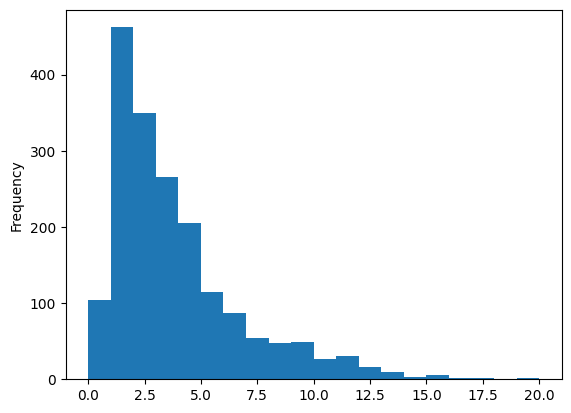

In [48]:
prescriptions_df["count"].plot(kind="hist", bins=20)

In [65]:
prescriptions_df.groupby("count")["prescription"].count().sort_values(ascending=False).head(10)

count
1    462
2    349
3    266
4    205
5    115
0    104
6     87
7     54
9     49
8     48
Name: prescription, dtype: int64

In [64]:
prescriptions_df["count"].describe()

count    1836.000000
mean        3.390523
std         2.962343
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        20.000000
Name: count, dtype: float64

## Nombre d'ordonnance identique

In [88]:
prescriptions_df["prescription_ux"] = prescriptions_df["prescription"].apply(lambda x: frozenset([i["key"] for i in x]))

prescriptions_ux_df = pd.DataFrame(
    prescriptions_df.groupby("prescription_ux")["count"].count().sort_values(ascending=False)
).reset_index()

prescriptions_ux_df["medicament_count"] = prescriptions_ux_df["prescription_ux"].apply(lambda x: len(x))
prescriptions_ux_df.sort_values("count", ascending=False).head(100)

,prescription_ux,count,medicament_count
0,(),104,0
1,(7024),22,1
2,"(4968, 1234)",10,2
3,(1052),10,1
4,(4974),9,1
...,...,...,...
93,(7494),2,1
56,"(6281, 5749, 949)",2,3
66,(4945),2,1
65,(3168),2,1


# Quels médicaments sont équivalents ?
 

In [125]:
import itertools

medicament_pairs = {}

for med_pair in itertools.combinations(medecine_dictionary["key"], 2):
    medicament_pairs[frozenset(med_pair)] = 0

for i, prescription in prescriptions_ux_df[prescriptions_ux_df["medicament_count"] > 1].iterrows():

    for prescription_med_pair in itertools.combinations(prescription["prescription_ux"], 2):
        medicament_pairs[frozenset(prescription_med_pair)] += 1

In [126]:
medicament_pairs

{frozenset({8, 10}): 0,
 frozenset({8, 12}): 0,
 frozenset({8, 24}): 0,
 frozenset({8, 27}): 0,
 frozenset({8, 29}): 0,
 frozenset({8, 34}): 0,
 frozenset({8, 36}): 0,
 frozenset({8, 44}): 0,
 frozenset({8, 50}): 0,
 frozenset({8, 57}): 1,
 frozenset({8, 77}): 0,
 frozenset({8, 78}): 0,
 frozenset({8, 80}): 0,
 frozenset({8, 88}): 0,
 frozenset({8, 108}): 0,
 frozenset({8, 114}): 0,
 frozenset({8, 115}): 0,
 frozenset({8, 119}): 0,
 frozenset({8, 127}): 0,
 frozenset({8, 137}): 0,
 frozenset({8, 139}): 0,
 frozenset({8, 142}): 0,
 frozenset({8, 146}): 0,
 frozenset({8, 147}): 0,
 frozenset({8, 149}): 0,
 frozenset({8, 150}): 0,
 frozenset({8, 159}): 0,
 frozenset({8, 162}): 0,
 frozenset({8, 164}): 0,
 frozenset({8, 166}): 0,
 frozenset({8, 168}): 1,
 frozenset({8, 173}): 0,
 frozenset({8, 183}): 0,
 frozenset({8, 205}): 0,
 frozenset({8, 208}): 0,
 frozenset({8, 223}): 0,
 frozenset({8, 240}): 1,
 frozenset({8, 245}): 0,
 frozenset({8, 269}): 0,
 frozenset({8, 271}): 0,
 frozenset({8,